In [2]:

!pip install setuptools
!pip install fiftyone --upgrade --quiet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\gmuke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\gmuke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\gmuke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!pip install imagehash


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\gmuke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
import os

import imagehash
from PIL import Image

import pandas as pd

print("FiftyOne imported successfully!")


FiftyOne imported successfully!


In [3]:
# Safe cleanup: avoid database operations
try:
    # Delete any default in-memory dataset if it exists
    fo.delete_default_dataset()
    print(" Old default dataset deleted successfully.")
except:
    print(" MongoDB disabled — skipped dataset deletion safely.")

print("✅ Ready to create a new dataset.")


 MongoDB disabled — skipped dataset deletion safely.
✅ Ready to create a new dataset.


In [4]:

fo.config.database_validation = False
for name in fo.list_datasets():
    fo.delete_dataset(name)
print("🧹 All old datasets deleted.")

data_dir = r"C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig"
dataset = fo.Dataset.from_dir(
    dataset_dir=data_dir,
    dataset_type=fo.types.ImageDirectory,
    name="image_dedup_dataset"
)
print(f"✅ Loaded {len(dataset)} images.")


🧹 All old datasets deleted.
 100% |███████████████████| 51/51 [86.0ms elapsed, 0s remaining, 593.2 samples/s]  
✅ Loaded 51 images.


In [5]:
# Load pretrained model
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

# Compute embeddings for all images
dataset.compute_embeddings(model, embeddings_field="embeddings")

print("✅ Embeddings computed for all images.")


 100% |███████████████████| 51/51 [55.4s elapsed, 0s remaining, 0.9 samples/s]    
✅ Embeddings computed for all images.


In [6]:
print(dataset.count("embeddings"))


51


In [7]:
print(dataset.list_brain_runs())


[]


In [13]:
index = dataset.load_brain_results("face_sim")
print(index)


{
    "cls": "fiftyone.brain.internal.core.sklearn.SklearnSimilarityIndex"
}


   2% ||------------------|  1/51 [30.4ms elapsed, 1.5s remaining, 32.9 samples/s] 

 100% |███████████████████| 51/51 [62.0ms elapsed, 0s remaining, 822.9 samples/s]  
✅ Loaded dataset with 51 images
🔍 Computing perceptual hashes...
🔗 Finding duplicate/similar images...
✅ Found 8 potential duplicates:
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121631.jpg ↔ C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121632.jpg (distance=8)
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121742.jpg ↔ C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121745.jpg (distance=12)
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121742.jpg ↔ C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121746.jpg (distance=12)
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121742.jpg ↔ C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121746_01.jpg (distance=12)
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121745.jpg ↔ C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121746.jpg (distance=2)
 - C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig\IMG20231117121745.jpg ↔ C:\Users\


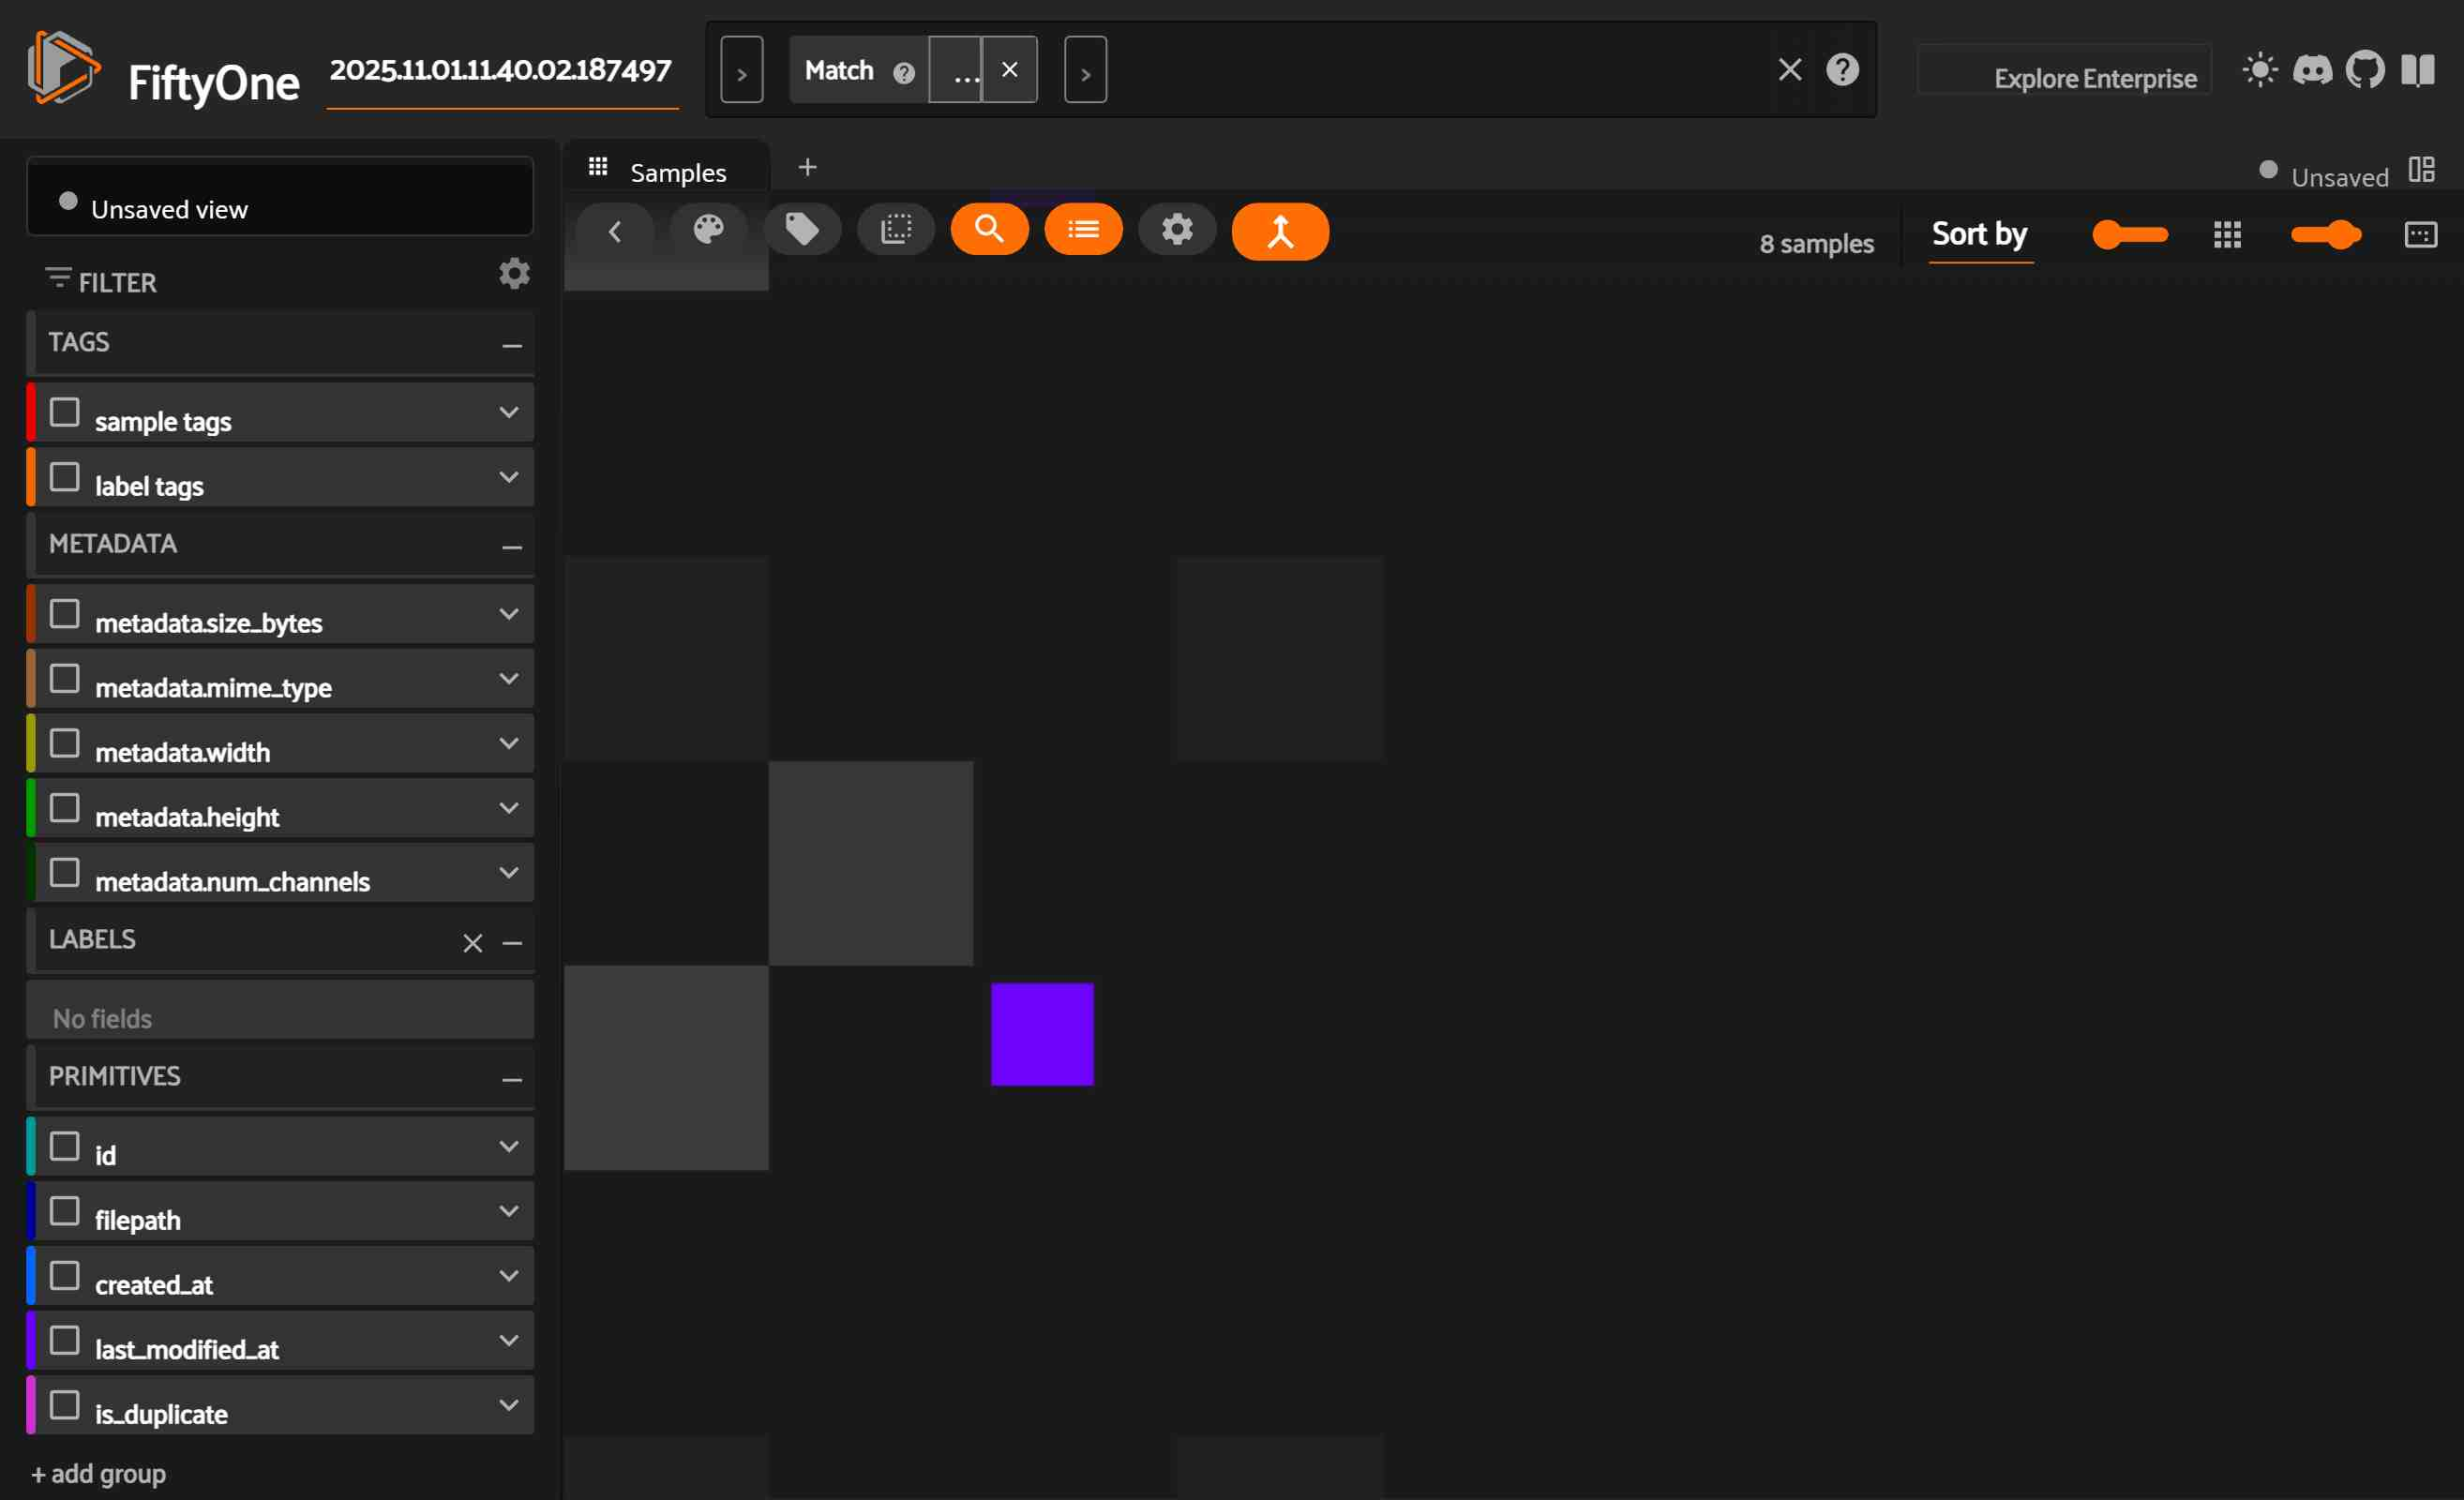


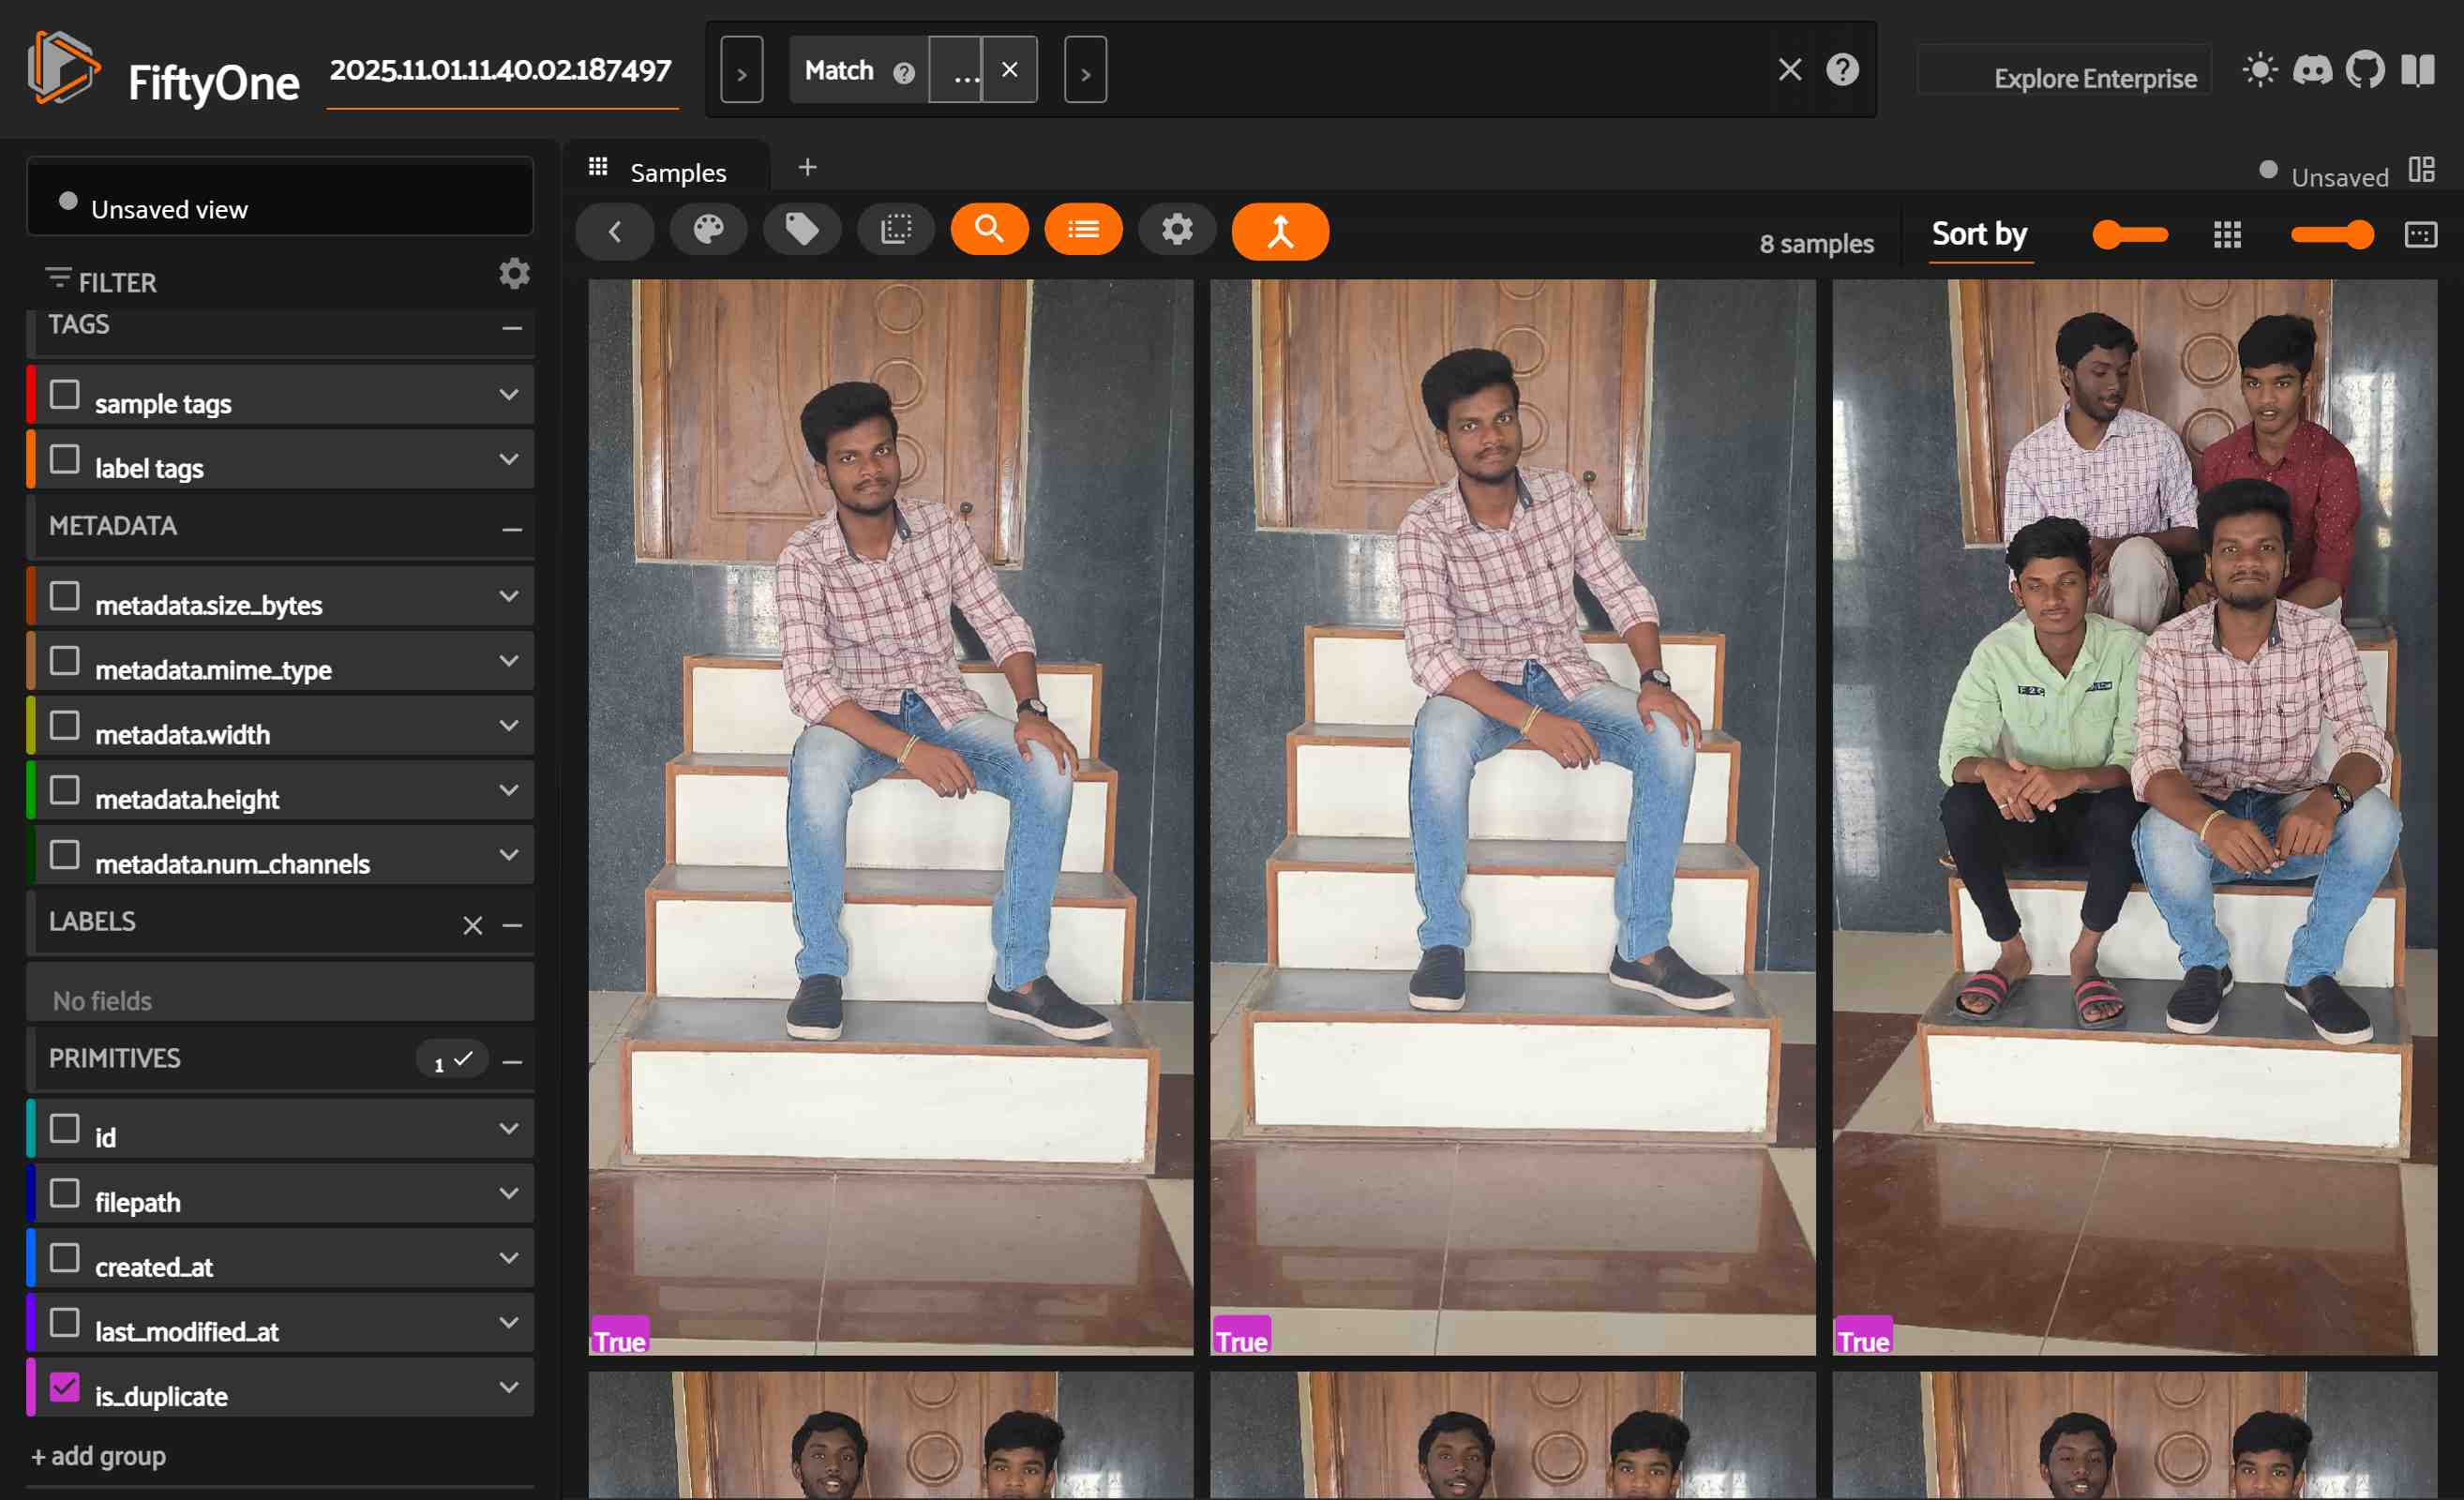

✅ Open the FiftyOne App to explore visually similar/duplicate images.
💡 Tip: Use filters (left panel) → `is_duplicate = True` to focus on duplicates.


In [ ]:
dataset_dir = r"C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig"

#  Step 1: Create FiftyOne dataset
dataset = fo.Dataset.from_dir(dataset_dir, fo.types.ImageDirectory)
print(f"✅ Loaded dataset with {len(dataset)} images")

# Step 2: Compute perceptual hashes (phash)
print("🔍 Computing perceptual hashes...")
hashes = {}
for sample in dataset:
    try:
        img = Image.open(sample.filepath)
        hashes[sample.id] = imagehash.phash(img)
    except Exception as e:
        print(f" Error reading {sample.filepath}: {e}")

# Step 3: Compare hashes to find duplicates
print("🔗 Finding duplicate/similar images...")
duplicates = []
threshold = 15  #  Increase for more lenient detection (8–15 typical)

sample_ids = list(hashes.keys())
for i in range(len(sample_ids)):
    for j in range(i + 1, len(sample_ids)):
        h1, h2 = hashes[sample_ids[i]], hashes[sample_ids[j]]
        dist = h1 - h2
        if dist <= threshold:
            duplicates.append((sample_ids[i], sample_ids[j], dist))

# Step 4: Print results
if duplicates:
    print(f"✅ Found {len(duplicates)} potential duplicates:")
    for d in duplicates:
        s1, s2, dist = d
        print(f" - {dataset[s1].filepath} ↔ {dataset[s2].filepath} (distance={dist})")
else:
    print("⚠️ No duplicates found. Try increasing threshold (e.g., 12–15).")

# 🖼️ Step 5: Add duplicate info to FiftyOne dataset for visualization
print("📊 Adding duplicate metadata to FiftyOne dataset...")

# Create a field to mark duplicates
dataset.add_sample_field("is_duplicate", fo.BooleanField)

# Mark duplicate pairs
duplicate_ids = set()
for s1, s2, _ in duplicates:
    duplicate_ids.add(s1)
    duplicate_ids.add(s2)

for sample in dataset:
    sample["is_duplicate"] = sample.id in duplicate_ids
    sample.save()

# 🧭 Step 6: Launch FiftyOne app for exploration
print("🚀 Launching FiftyOne App...")
fo.close_app()
session = fo.launch_app(dataset)
session.view = dataset.match({"is_duplicate": True})

print("✅ Open the FiftyOne App to explore visually similar/duplicate images.")
print("💡 Tip: Use filters (left panel) → `is_duplicate = True` to focus on duplicates.")


In [16]:



# Step 1: Compute pairwise similarity
results = []
threshold = 10  # smaller → stricter match

sample_ids = list(hashes.keys())

for i in range(len(sample_ids)):
    for j in range(i + 1, len(sample_ids)):
        h1, h2 = hashes[sample_ids[i]], hashes[sample_ids[j]]
        dist = h1 - h2
        similarity = round(100 - (dist / 64 * 100), 2)
        results.append({
            "Sample1": sample_ids[i],
            "Sample2": sample_ids[j],
            "Image 1": os.path.basename(dataset[sample_ids[i]].filepath),
            "Image 2": os.path.basename(dataset[sample_ids[j]].filepath),
            "Distance": dist,
            "Similarity (%)": similarity
        })

# Step 2: Sort & show top results
df = pd.DataFrame(results).sort_values("Similarity (%)", ascending=False)
display(df.head(10))

# Step 3: Filter likely duplicates
duplicates = df[df["Distance"] <= threshold]
print(f"🧩 Found {len(duplicates)} duplicate/similar pairs (distance ≤ {threshold})")

# Step 4: Build grouped view for FiftyOne
if not duplicates.empty:
    # 🧹 Delete old dataset if it already exists
    if "duplicates_view" in fo.list_datasets():
        fo.delete_dataset("duplicates_view")

    # Create a fresh dataset
    dup_dataset = fo.Dataset("duplicates_view")
    dup_dataset.persistent = False

    for _, row in duplicates.iterrows():
        s1 = dataset[row["Sample1"]]
        s2 = dataset[row["Sample2"]]

        group = fo.Group()
        left = fo.Sample(filepath=s1.filepath, group=group.element("left"))
        right = fo.Sample(filepath=s2.filepath, group=group.element("right"))

        # store similarity for reference
        left["similarity"] = row["Similarity (%)"]
        right["similarity"] = row["Similarity (%)"]

        dup_dataset.add_samples([left, right])

    print(f"✅ Created grouped duplicate dataset with {len(dup_dataset)} samples")

    # Step 5: Launch FiftyOne App
    fo.close_app()
    session = fo.launch_app(dup_dataset)
    session.group_slice = "left"

    print("🚀 FiftyOne launched — duplicate image pairs shown side by side!")
    print("💡 Tip: Use the group switcher (top bar) to toggle between 'left' and 'right'.")
else:
    print("⚠️ No duplicates found — try increasing threshold or check image quality.")


,Sample1,Sample2,Image 1,Image 2,Distance,Similarity (%)
680,6905a43a22dd7bdc2cdce508,6905a43a22dd7bdc2cdce509,IMG20231117121746.jpg,IMG20231117121746_01.jpg,0,100.00
897,6905a43a22dd7bdc2cdce50f,6905a43a22dd7bdc2cdce510,IMG20231118184757_01 - Copy (2).jpg,IMG20231118184757_01 - Copy (3).jpg,0,100.00
646,6905a43a22dd7bdc2cdce507,6905a43a22dd7bdc2cdce509,IMG20231117121745.jpg,IMG20231117121746_01.jpg,2,96.88
645,6905a43a22dd7bdc2cdce507,6905a43a22dd7bdc2cdce508,IMG20231117121745.jpg,IMG20231117121746.jpg,2,96.88
534,6905a43a22dd7bdc2cdce504,6905a43a22dd7bdc2cdce505,IMG20231117121631.jpg,IMG20231117121632.jpg,8,87.50
610,6905a43a22dd7bdc2cdce506,6905a43a22dd7bdc2cdce508,IMG20231117121742.jpg,IMG20231117121746.jpg,12,81.25
609,6905a43a22dd7bdc2cdce506,6905a43a22dd7bdc2cdce507,IMG20231117121742.jpg,IMG20231117121745.jpg,12,81.25
611,6905a43a22dd7bdc2cdce506,6905a43a22dd7bdc2cdce509,IMG20231117121742.jpg,IMG20231117121746_01.jpg,12,81.25
1224,6905a43a22dd7bdc2cdce520,6905a43a22dd7bdc2cdce525,JNTUACEA.jpg,Screenshot_2025-04-04-10-47-31-26_6012fa4d4dde...,20,68.75
469,6905a43a22dd7bdc2cdce502,6905a43a22dd7bdc2cdce511,IMG-20250806-WA0005.jpg,IMG20231118190104.jpg,20,68.75


🧩 Found 5 duplicate/similar pairs (distance ≤ 10)
 100% |█████████████████████| 2/2 [103.7ms elapsed, 0s remaining, 19.3 samples/s]    
 100% |█████████████████████| 2/2 [9.1ms elapsed, 0s remaining, 219.1 samples/s]    
 100% |█████████████████████| 2/2 [11.7ms elapsed, 0s remaining, 170.4 samples/s]   
 100% |█████████████████████| 2/2 [10.8ms elapsed, 0s remaining, 185.8 samples/s]   
 100% |█████████████████████| 2/2 [10.0ms elapsed, 0s remaining, 199.4 samples/s]   
✅ Created grouped duplicate dataset with 5 samples


🚀 FiftyOne launched — duplicate image pairs shown side by side!
💡 Tip: Use the group switcher (top bar) to toggle between 'left' and 'right'.


In [1]:
# ✅ Check Installed Packages and Versions (for your project)

import importlib

# List of required packages (as per your notebook)
required_packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "PIL",          # pillow
    "imagehash",
    "fiftyone",
    "tqdm"
]

print("📦 Environment Verification Report")
print("====================================\n")

for pkg in required_packages:
    try:
        module = importlib.import_module(pkg if pkg != "PIL" else "PIL.Image")
        version = getattr(module, "__version__", "N/A")
        print(f"✅ {pkg:<12} — Version: {version}")
    except ModuleNotFoundError:
        print(f"❌ {pkg:<12} — Not Installed")

print("\n🔍 Tip: Install missing packages using:")
print("   pip install -r requirements.txt")


📦 Environment Verification Report

✅ numpy        — Version: 2.1.2
✅ pandas       — Version: 2.2.3
✅ matplotlib   — Version: 3.9.2
✅ seaborn      — Version: 0.13.2
✅ PIL          — Version: 11.0.0
✅ imagehash    — Version: 4.3.2


C:\Users\gmuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ fiftyone     — Version: 1.9.0
✅ tqdm         — Version: 4.67.1

🔍 Tip: Install missing packages using:
   pip install -r requirements.txt


In [2]:
# Check installed packages and versions
import pkg_resources

# List of packages to check (from your requirements)
packages_to_check = [
    'setuptools', 'fiftyone', 'torch', 'torchvision', 'torchaudio', 
    'imagehash', 'Pillow', 'pandas', 'numpy', 'scipy', 'PyWavelets',
    'filelock', 'typing_extensions', 'sympy', 'networkx', 'jinja2',
    'fsspec', 'mpmath', 'MarkupSafe'
]

print("📦 Installed Packages and Versions:")
print("=" * 50)

for package in packages_to_check:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"✅ {package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"❌ {package}: NOT INSTALLED")

print("\n" + "=" * 50)

# Additional system info
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check CUDA availability for PyTorch
try:
    import torch
    print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"PyTorch CUDA version: {torch.version.cuda}")
except ImportError:
    print("PyTorch not available for CUDA check")

C:\Users\gmuke\AppData\Local\Temp\ipykernel_47552\494305693.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📦 Installed Packages and Versions:
✅ setuptools: 80.9.0
✅ fiftyone: 1.9.0
✅ torch: 2.9.0+cpu
✅ torchvision: 0.24.0+cpu
✅ torchaudio: 2.9.0+cpu
✅ imagehash: 4.3.2
✅ Pillow: 11.0.0
✅ pandas: 2.2.3
✅ numpy: 2.1.2
✅ scipy: 1.15.2
✅ PyWavelets: 1.9.0
✅ filelock: 3.19.1
✅ typing_extensions: 4.15.0
✅ sympy: 1.14.0
✅ networkx: 3.5
✅ jinja2: 3.1.5
✅ fsspec: 2025.9.0
✅ mpmath: 1.3.0
✅ MarkupSafe: 3.0.2

Python version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
Python executable: C:\Users\gmuke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe
PyTorch CUDA available: False


In [17]:

print(fo.__version__)
print(dataset)
print(len(dataset))
print(dataset.media_type)


1.9.0
Name:        2025.11.01.11.40.02.187497
Media type:  image
Num samples: 51
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    is_duplicate:     fiftyone.core.fields.BooleanField
51
image


📁 Found 51 images.

📊 Similarity Matrix (top 5 rows):
                CHEMISTRY.webp  CIVIL.webp  CSE3.webp  CSE4.jpg  CSE5.webp  \
CHEMISTRY.webp         100.000      50.000     59.375    56.250     46.875   
CIVIL.webp              50.000     100.000     56.250    46.875     46.875   
CSE3.webp               59.375      56.250    100.000    53.125     56.250   
CSE4.jpg                56.250      46.875     53.125   100.000     46.875   
CSE5.webp               46.875      46.875     56.250    46.875    100.000   

                CSE6.webp  CSE7.webp  ECE.webp  EEE LAB.webp  EEE NIGHT.jpg  \
CHEMISTRY.webp     59.375     56.250    43.750        50.000         46.875   
CIVIL.webp         50.000     53.125    43.750        53.125         53.125   
CSE3.webp          53.125     56.250    53.125        56.250         43.750   
CSE4.jpg           53.125     50.000    59.375        53.125         46.875   
CSE5.webp          53.125     53.125    43.750        53.125         46.875   

  

C:\Users\gmuke\AppData\Local\Temp\ipykernel_55456\2642213747.py:62: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gmuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


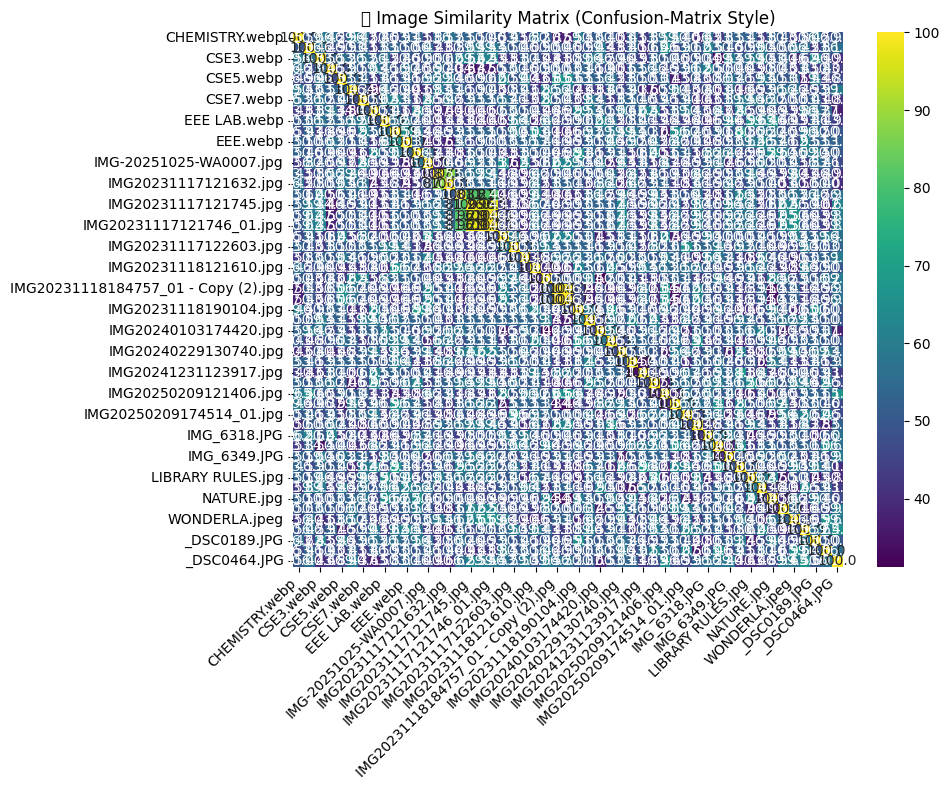

C:\Users\gmuke\AppData\Local\Temp\ipykernel_55456\2642213747.py:73: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gmuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


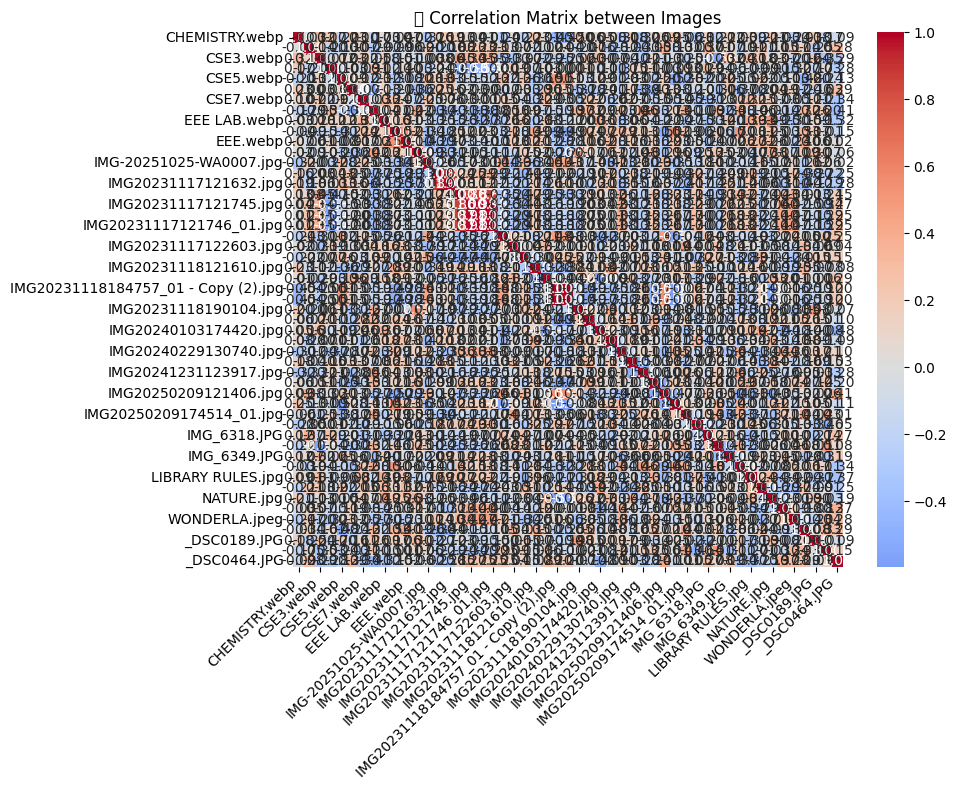

C:\Users\gmuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


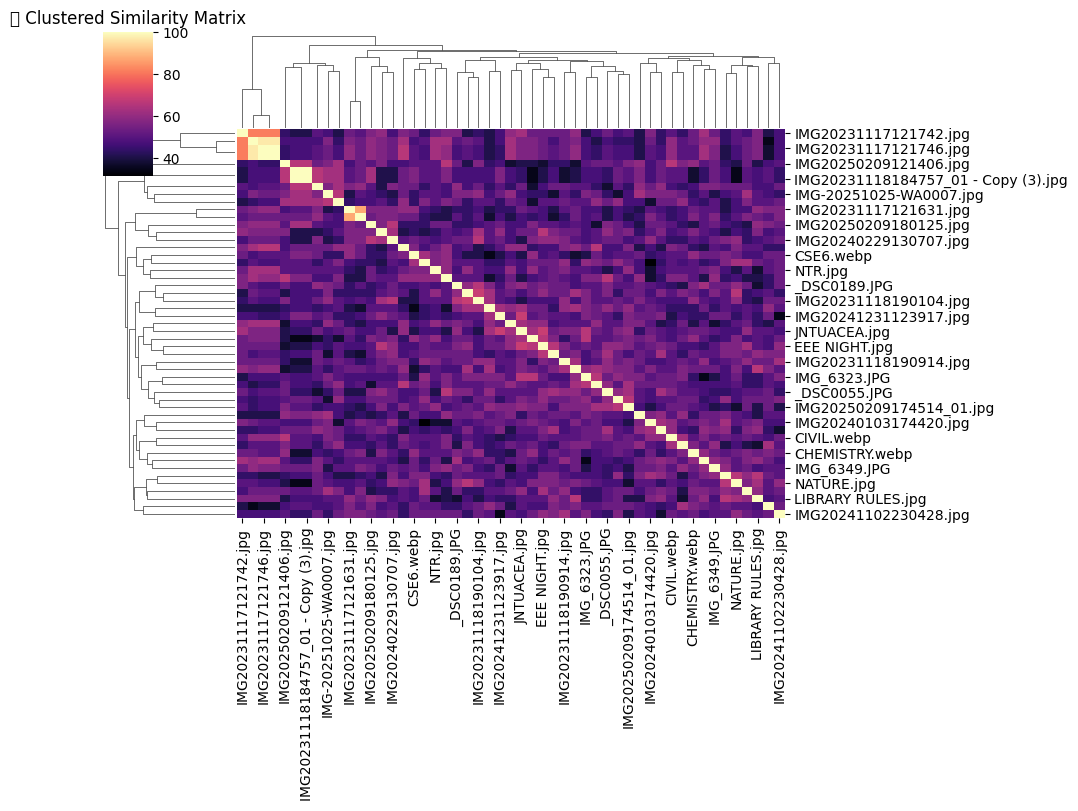


✅ Potential duplicate/similar pairs (≥90% similarity):
 - IMG20231117121745.jpg  ↔  IMG20231117121746.jpg  (96.88%)
 - IMG20231117121745.jpg  ↔  IMG20231117121746_01.jpg  (96.88%)
 - IMG20231117121746.jpg  ↔  IMG20231117121746_01.jpg  (100.0%)
 - IMG20231118184757_01 - Copy (2).jpg  ↔  IMG20231118184757_01 - Copy (3).jpg  (100.0%)


In [3]:
# =========================================
# 🧠 IMAGE SIMILARITY DATA VISUALIZATION MATRICES
# =========================================

import os
import numpy as np
import pandas as pd
from PIL import Image
import imagehash
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1️⃣: Path to image directory
dataset_dir = r"C:\Users\gmuke\Desktop\IDEAS-TIH\oo\ig"

# Step 2️⃣: Collect image file paths
image_files = [
    os.path.join(dataset_dir, f)
    for f in os.listdir(dataset_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png",".webp"))
]

print(f"📁 Found {len(image_files)} images.")

# Step 3️⃣: Compute perceptual hashes
hashes = []
for f in image_files:
    try:
        img = Image.open(f)
        h = imagehash.phash(img)
        hashes.append(h)
    except Exception as e:
        print(f"⚠️ Skipping {f}: {e}")
        hashes.append(None)

# Step 4️⃣: Build similarity matrix (100% = identical)
n = len(image_files)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if hashes[i] is not None and hashes[j] is not None:
            dist = hashes[i] - hashes[j]
            similarity = 100 - (dist / 64 * 100)
            similarity_matrix[i, j] = similarity

# Step 5️⃣: Convert to DataFrame (matrix form)
df_sim = pd.DataFrame(
    similarity_matrix,
    index=[os.path.basename(f) for f in image_files],
    columns=[os.path.basename(f) for f in image_files]
)

print("\n📊 Similarity Matrix (top 5 rows):")
print(df_sim.head())

# Step 6️⃣: Visualize as heatmap (Confusion Matrix Style)
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, cmap="viridis", annot=True, fmt=".1f")
plt.title("🧩 Image Similarity Matrix (Confusion-Matrix Style)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 7️⃣: Correlation matrix (treating similarity as numeric features)
corr_matrix = df_sim.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("🔗 Correlation Matrix between Images")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 8️⃣: Clustered heatmap (groups similar images automatically)
sns.clustermap(df_sim, cmap="magma", figsize=(10, 8))
plt.title("🧠 Clustered Similarity Matrix")
plt.show()

# Step 9️⃣: Identify duplicates (threshold-based)
threshold = 90
duplicates = []
for i in range(n):
    for j in range(i + 1, n):
        if similarity_matrix[i, j] >= threshold:
            duplicates.append((os.path.basename(image_files[i]),
                               os.path.basename(image_files[j]),
                               round(similarity_matrix[i, j], 2)))

if duplicates:
    print("\n✅ Potential duplicate/similar pairs (≥90% similarity):")
    for a, b, s in duplicates:
        print(f" - {a}  ↔  {b}  ({s}%)")
else:
    print("\n⚠️ No duplicates found above 90% similarity.")
